In [231]:
# 계산
import numpy as np
from scipy.stats import mode
from collections import Counter
import time

# 전처리
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GroupKFold, TimeSeriesSplit
from imblearn.over_sampling import SMOTE

# 데이터셋 로드 및 정제
import os
import random
import joblib
import pandas as pd

# visualization
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 모델링
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import catboost
from catboost import CatBoostRegressor, Pool

# 스케일링
from sklearn.preprocessing import StandardScaler

# 평가지표
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import r2_score
# import eli5
# from eli5.sklearn import PermutationImportance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# hyperparameter tuning
import optuna
from functools import partial

# feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score


# 코드 셀 실행 후 경고를 무시
import warnings
warnings.filterwarnings(action='ignore')

In [232]:
# 필요한 데이터를 load 하겠습니다. 경로는 환경에 맞게 지정해주면 됩니다.
train_path = './train.csv'
test_path  = './test.csv'
df = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print(df.shape, test.shape)

(252289, 19) (79786, 18)


In [233]:
df.describe()

,TARGET,new,quality,duration,bounced,transaction,transaction_revenue
count,252289.000000,252289.000000,252289.000000,252289.000000,252289.000000,252289.000000,2.522890e+05
mean,3.592626,0.751955,3.816805,113.104253,0.493672,0.009033,9.061248e+05
std,5.509465,0.431879,11.091028,330.876019,0.499961,0.100938,2.127689e+07
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000e+00
75%,4.000000,1.000000,1.000000,71.000000,1.000000,0.000000,0.000000e+00
max,386.000000,1.000000,98.000000,11186.000000,1.000000,12.000000,3.325712e+09


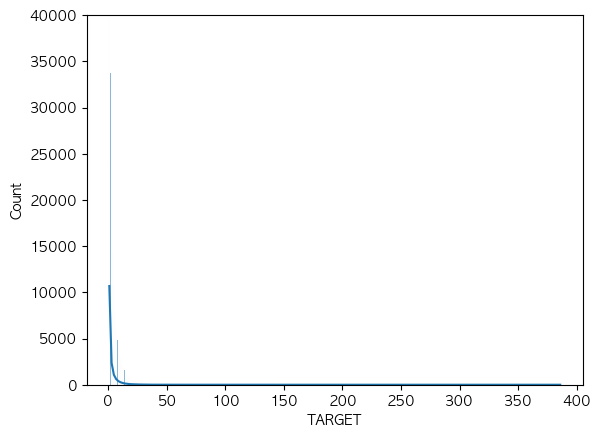

In [234]:
# 데이터를 시각화
sns.histplot(x='TARGET', data=df, kde=True)

plt.ylim(0, 40000)

# 그래프를 표시
plt.show()

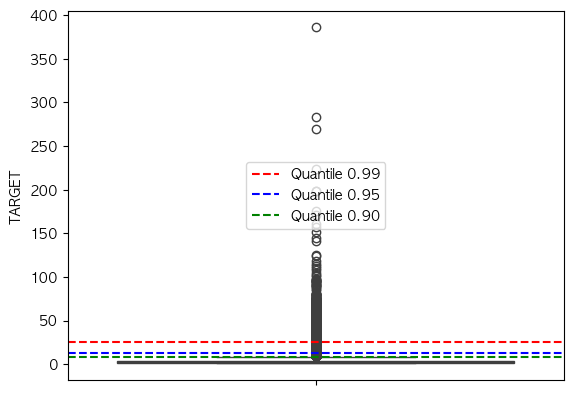

99% : 26.0 95% : 13.0 90% : 8.0


In [235]:
sns.boxplot(y='TARGET', data=df)

# quantile(0.99), quantile(0.95), quantile(0.90) 계산
q99 = np.quantile(df['TARGET'], 0.99)
q95 = np.quantile(df['TARGET'], 0.95)
q90 = np.quantile(df['TARGET'], 0.90)
    
# 점선 추가
plt.axhline(y=q99, color='red', linestyle='--', label='Quantile 0.99')
plt.axhline(y=q95, color='blue', linestyle='--', label='Quantile 0.95')
plt.axhline(y=q90, color='green', linestyle='--', label='Quantile 0.90')
plt.legend(loc="center")

plt.show()

print('99% :', q99, '95% :', q95, '90% :', q90)

In [236]:
df['keyword'].fillna('NaN', inplace=True)
df['referral_path'].fillna('NaN', inplace=True)

In [237]:
test['keyword'].fillna('NaN', inplace=True)
test['referral_path'].fillna('NaN', inplace=True)

In [238]:
def remove_outliers(df, column_name):
    # 이상치를 제거할 데이터프레임 복사
    df_cleaned = df.copy()
    
    # IQR 계산
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    # 이상치 경계값 계산
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 이상치 제거
    df_cleaned = df_cleaned[(df_cleaned[column_name] >= lower_bound) & (df_cleaned[column_name] <= upper_bound)]
    
    return df_cleaned

In [239]:
def remove_percentile_outliers(df, column_name, percentile):
    # 이상치를 제거할 데이터프레임 복사
    df_cleaned = df.copy()
    
    # 백분위수 이상을 제거
    threshold = df[column_name].quantile(percentile)
    df_cleaned = df_cleaned[df_cleaned[column_name] <= threshold]
    
    return df_cleaned

In [240]:
# ###
# # Q1, Q3 계산
# Q1 = df['TARGET'].quantile(0.25)
# Q3 = df['TARGET'].quantile(0.75)
# IQR = Q3 - Q1

# upper_bound = Q3 + 1.5 * IQR
# quantile_90 = df['TARGET'].quantile(0.90)
# quantile_95 = df['TARGET'].quantile(0.95)
quantile_99 = df['TARGET'].quantile(0.99)
df['Outlier'] = (df['TARGET'] > quantile_99).astype(int)

In [241]:
df.isna().sum()

sessionID              0
userID                 0
TARGET                 0
browser                0
OS                     0
device                 0
new                    0
quality                0
duration               0
bounced                0
transaction            0
transaction_revenue    0
continent              0
subcontinent           0
country                0
traffic_source         0
traffic_medium         0
keyword                0
referral_path          0
Outlier                0
dtype: int64

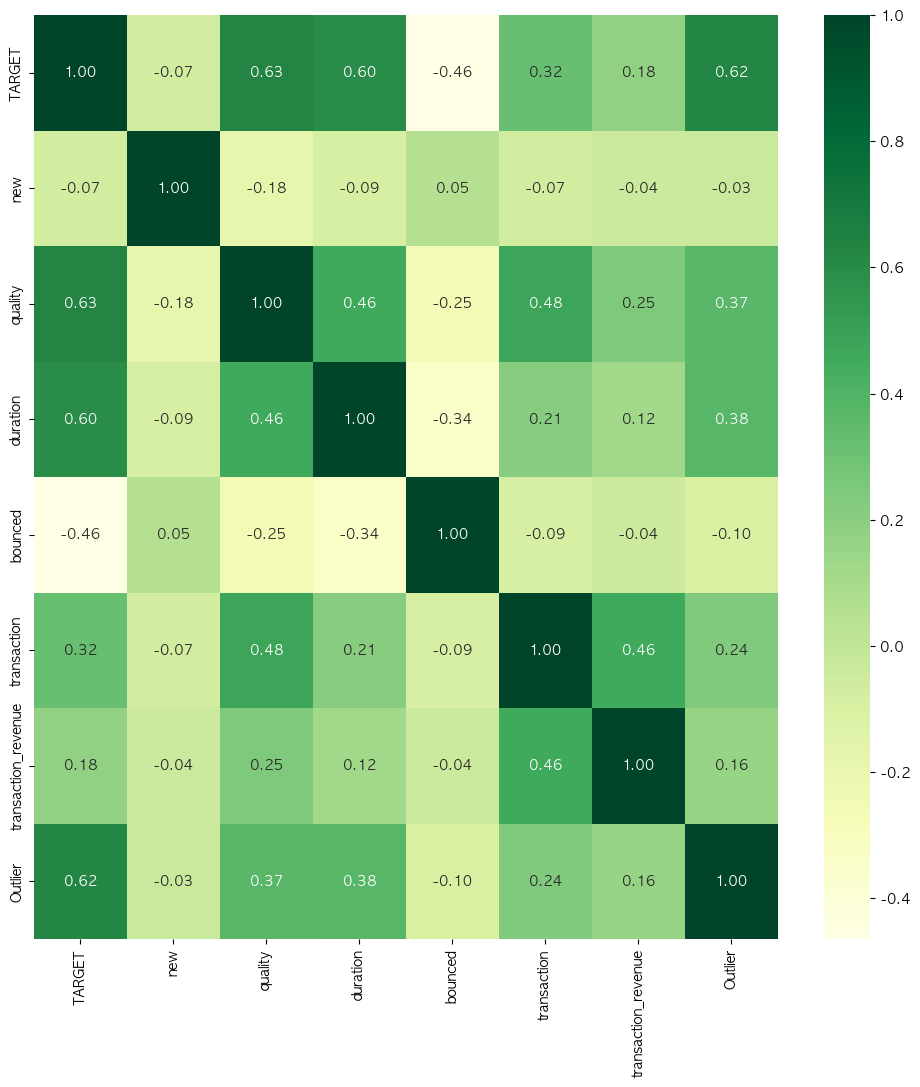

In [242]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGn', fmt='.2f')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

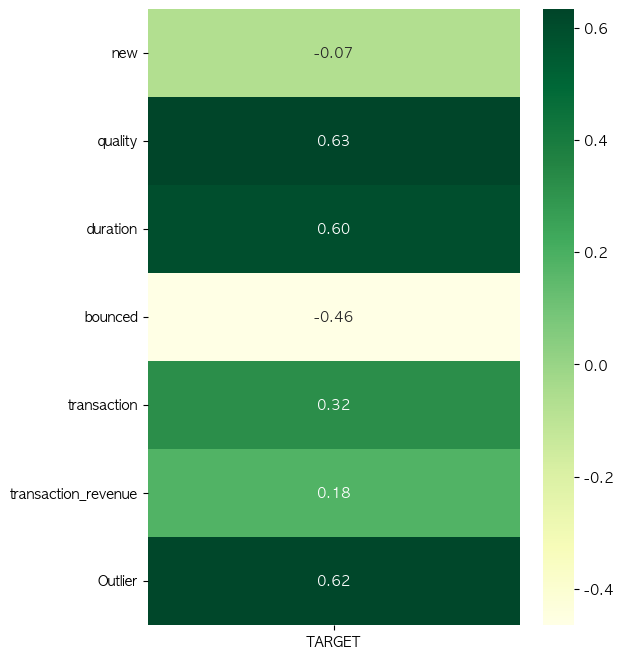

In [243]:
target_corr = correlation_matrix['TARGET'].drop('TARGET')
plt.figure(figsize=(6,8))
sns.heatmap(pd.DataFrame(target_corr), annot=True, cmap='YlGn', fmt='.2f')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

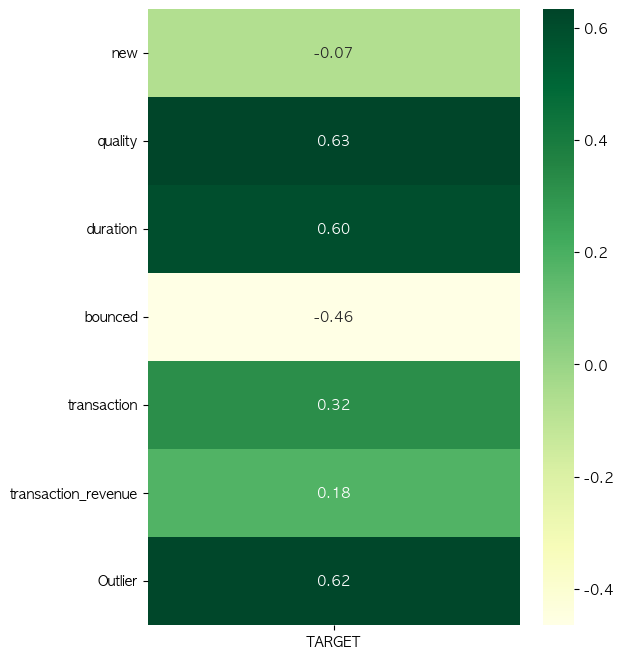

In [244]:
target_corr = correlation_matrix['TARGET'].drop('TARGET')
plt.figure(figsize=(6,8))
sns.heatmap(pd.DataFrame(target_corr), annot=True, cmap='YlGn', fmt='.2f')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

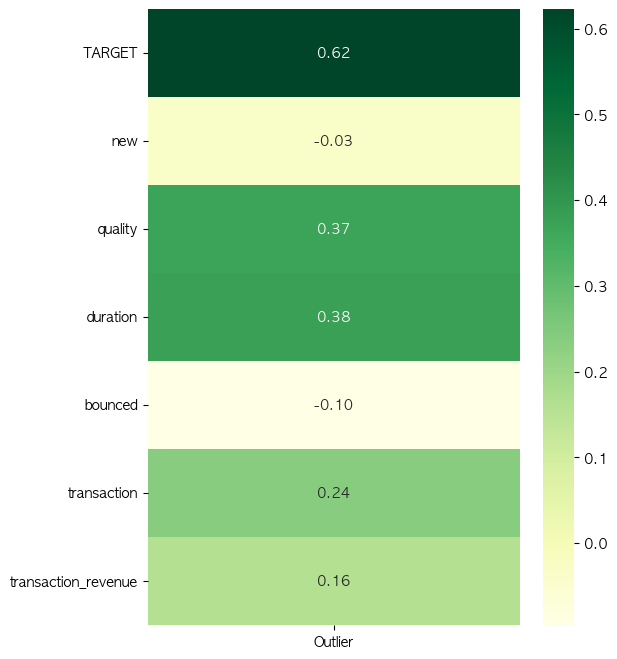

In [245]:
target_corr = correlation_matrix['Outlier'].drop('Outlier')
plt.figure(figsize=(6,8))
sns.heatmap(pd.DataFrame(target_corr), annot=True, cmap='YlGn', fmt='.2f')
plt.show

In [246]:
# 분할된 데이터를 fold별로 시각화하기 위한 함수를 구성합니다.
# Scikit-learn에서 https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html 사용한 코드를 가져와서 사용하겠습니다.
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(x, y, cv, ax, split_strategy='KFold', group=None, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    for ii, (tr, tt) in enumerate(cv.split(X=x, y=y, groups=group)):
        # Fill in indices with the training/test groups
        print(f"Fold {ii} :")
        print(f"  Train : index={tr[:5]}...")
        print(f"  Valid : index={tt[:5]}...")
        indices = np.array([np.nan] * len(x))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=0.2,
        )

    # Formatting
    yticklabels = list(range(5))

    ax.set(
        yticks=np.arange(len(yticklabels)) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[len(yticklabels) + 0.2, -0.2],
        xlim=[0, len(x)],
    )
    ax.set_title(split_strategy, fontsize=15)
    return ax

In [247]:
# DataFrame을 랜덤하게 섞고 인덱스 초기화
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [248]:
X = df.drop(columns=['sessionID', 'TARGET', 'Outlier']) # sessionID는 1개 씩 밖에 없음
y = df['Outlier']

print(X.shape, y.shape)

(252289, 17) (252289,)


In [249]:
# train_test_split() 함수로 학습 데이터와 테스트 데이터 분리하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42, shuffle=False)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# # 전체 데이터 사용
# X_train = X
# y_train = y

(239674, 17) (239674,)
(12615, 17) (12615,)


In [250]:
# Kfold 함수를 선언합니다.
kf = KFold(n_splits=5)

Fold 0 :
  Train : index=[47935 47936 47937 47938 47939]...
  Valid : index=[0 1 2 3 4]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[47935 47936 47937 47938 47939]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[95870 95871 95872 95873 95874]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[143805 143806 143807 143808 143809]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[191740 191741 191742 191743 191744]...


<Axes: title={'center': 'K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

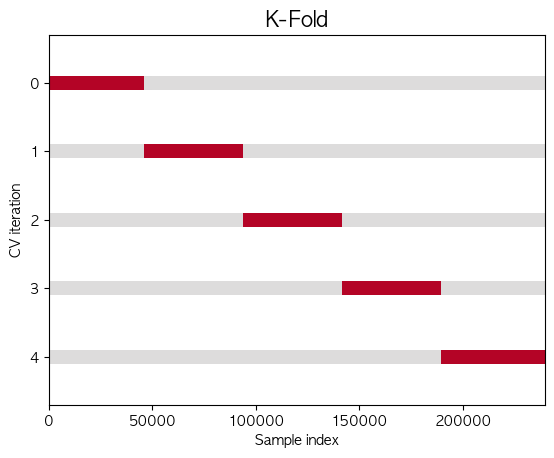

In [251]:
# kfold를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train,
                y=y_train,
                cv=kf,
                ax=ax,
                split_strategy='K-Fold')

In [252]:
# 학습 데이터를 Kfold로 나눕니다.
train_folds = kf.split(X_train, y_train)

In [253]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in df.columns.drop("TARGET"):
    if pd.api.types.is_numeric_dtype(df[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("범주형 변수:", categorical_columns_v2)
print("연속형 변수:", continuous_columns_v2)

범주형 변수: ['sessionID', 'userID', 'browser', 'OS', 'device', 'continent', 'subcontinent', 'country', 'traffic_source', 'traffic_medium', 'keyword', 'referral_path']
연속형 변수: ['new', 'quality', 'duration', 'bounced', 'transaction', 'transaction_revenue', 'Outlier']


In [254]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier

--------0번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.042632
0:	learn: 0.6004076	test: 0.6004773	best: 0.6004773 (0)	total: 135ms	remaining: 22m 32s
100:	learn: 0.0213430	test: 0.0216560	best: 0.0216560 (100)	total: 11.5s	remaining: 18m 46s
200:	learn: 0.0200021	test: 0.0207718	best: 0.0207718 (200)	total: 23.7s	remaining: 19m 14s
300:	learn: 0.0192715	test: 0.0204529	best: 0.0204504 (296)	total: 36s	remaining: 19m 20s
400:	learn: 0.0187137	test: 0.0202794	best: 0.0202794 (400)	total: 47.9s	remaining: 19m 6s
500:	learn: 0.0182986	test: 0.0201680	best: 0.0201680 (500)	total: 59.6s	remaining: 18m 49s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.02014287864
bestIteration = 542

Shrink model to first 543 iterations.


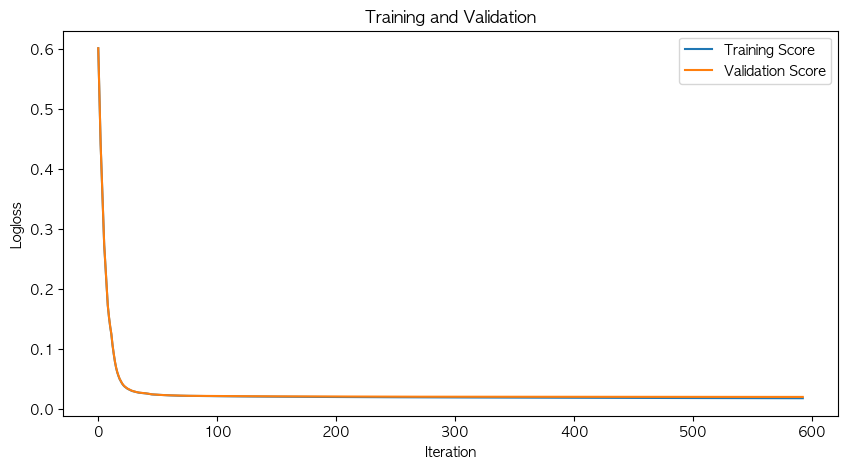

0번째 fold - accuracy: 0.9923020757275477, precision: 0.7136563876651982, recall: 0.34763948497854075, macro_f1: 0.7318277402226255
0번째 fold(TEST) - accuracy: 0.9922314704716607, precision: 0.5636363636363636, recall: 0.29523809523809524, macro_f1: 0.6917954726765058
--------1번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.042632
0:	learn: 0.6005650	test: 0.6005439	best: 0.6005439 (0)	total: 98.3ms	remaining: 16m 22s
100:	learn: 0.0213959	test: 0.0222795	best: 0.0222795 (100)	total: 11.5s	remaining: 18m 48s
200:	learn: 0.0200965	test: 0.0213443	best: 0.0213443 (200)	total: 24.1s	remaining: 19m 34s
300:	learn: 0.0193925	test: 0.0209988	best: 0.0209944 (297)	total: 36.2s	remaining: 19m 26s
400:	learn: 0.0187647	test: 0.0207604	best: 0.0207604 (400)	total: 48.3s	remaining: 19m 15s
500:	learn: 0.0183388	test: 0.0206119	best: 0.0206112 (499)	total: 1m	remaining: 19m 6s
600:	learn: 0.0179866	test: 0.0204950	best: 0.0204932 (598)	total: 1m 12s	remaining: 18m 55s
700:	learn: 0.0176687	test: 0

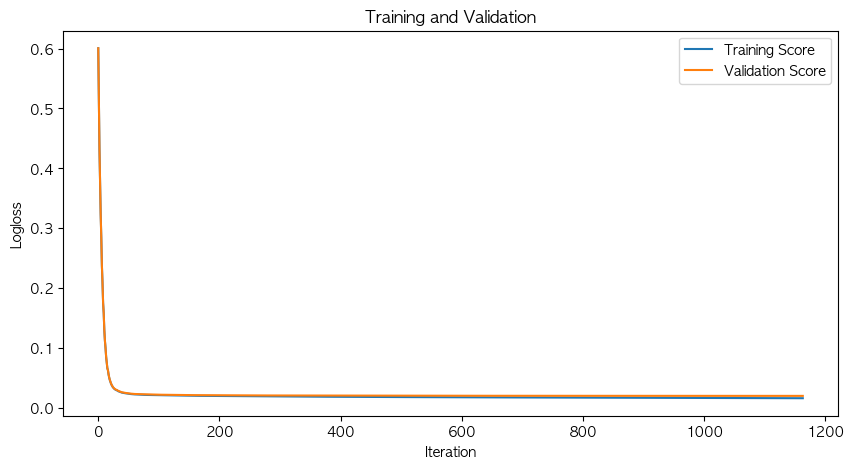

1번째 fold - accuracy: 0.9919682903932409, precision: 0.6615384615384615, recall: 0.28794642857142855, macro_f1: 0.6986005984782764
1번째 fold(TEST) - accuracy: 0.9924692826000793, precision: 0.5862068965517241, recall: 0.3238095238095238, macro_f1: 0.7066940354451298
--------2번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.042632
0:	learn: 0.6004580	test: 0.6004820	best: 0.6004820 (0)	total: 101ms	remaining: 16m 48s
100:	learn: 0.0213312	test: 0.0229407	best: 0.0229407 (100)	total: 12.2s	remaining: 19m 51s
200:	learn: 0.0199121	test: 0.0220506	best: 0.0220506 (200)	total: 25.3s	remaining: 20m 33s
300:	learn: 0.0192264	test: 0.0216771	best: 0.0216771 (300)	total: 38.1s	remaining: 20m 27s
400:	learn: 0.0187011	test: 0.0213925	best: 0.0213925 (400)	total: 50.8s	remaining: 20m 15s
500:	learn: 0.0182582	test: 0.0211864	best: 0.0211842 (490)	total: 1m 3s	remaining: 20m 3s
600:	learn: 0.0177895	test: 0.0210110	best: 0.0210103 (599)	total: 1m 16s	remaining: 20m
700:	learn: 0.0174601	test: 0.02

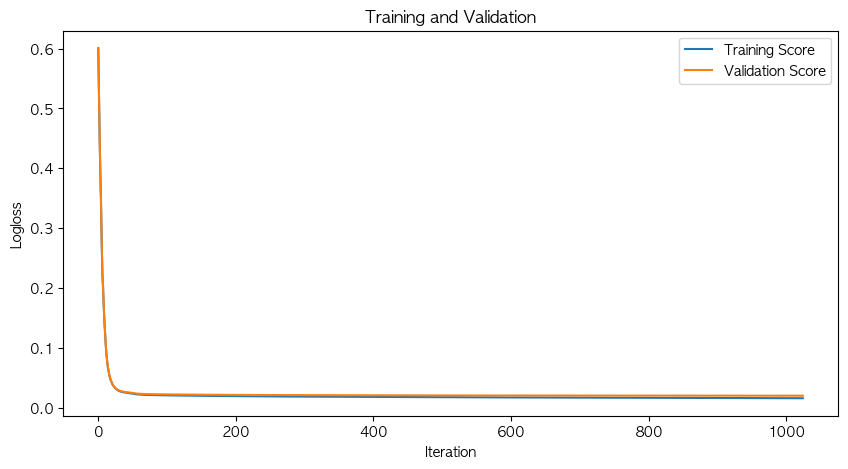

2번째 fold - accuracy: 0.9921769062271827, precision: 0.6666666666666666, recall: 0.3443708609271523, macro_f1: 0.7251043462267377
2번째 fold(TEST) - accuracy: 0.9926278240190249, precision: 0.603448275862069, recall: 0.3333333333333333, macro_f1: 0.7128688978568112
--------3번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.042632
0:	learn: 0.6006078	test: 0.6005739	best: 0.6005739 (0)	total: 130ms	remaining: 21m 35s
100:	learn: 0.0211690	test: 0.0220669	best: 0.0220669 (100)	total: 12.1s	remaining: 19m 47s
200:	learn: 0.0198695	test: 0.0212789	best: 0.0212789 (200)	total: 25s	remaining: 20m 17s
300:	learn: 0.0190310	test: 0.0209129	best: 0.0209129 (300)	total: 38s	remaining: 20m 25s
400:	learn: 0.0184472	test: 0.0207797	best: 0.0207771 (397)	total: 50.3s	remaining: 20m 4s
500:	learn: 0.0179932	test: 0.0206859	best: 0.0206804 (496)	total: 1m 3s	remaining: 19m 56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.0206598587
bestIteration = 530

Shrink model to first 531 i

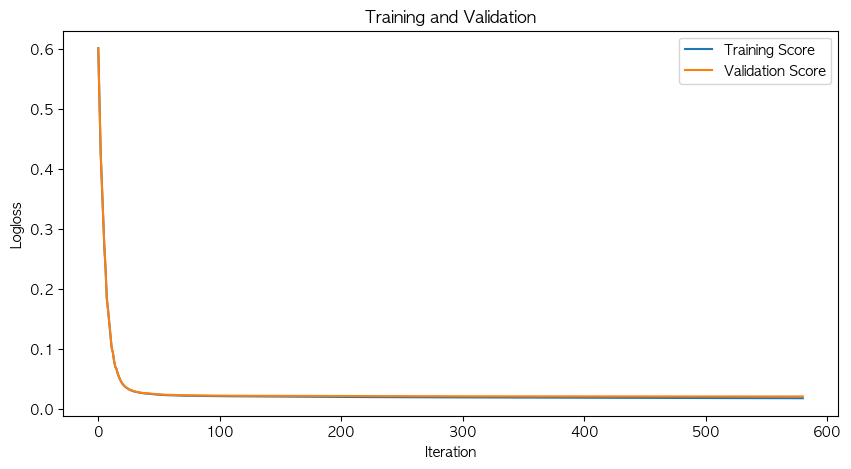

3번째 fold - accuracy: 0.9919891519766351, precision: 0.6580310880829016, recall: 0.2853932584269663, macro_f1: 0.6970434320962686
3번째 fold(TEST) - accuracy: 0.9923107411811336, precision: 0.5689655172413793, recall: 0.3142857142857143, macro_f1: 0.7005191730334484
--------4번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.042632
0:	learn: 0.5591488	test: 0.5590097	best: 0.5590097 (0)	total: 113ms	remaining: 18m 47s
100:	learn: 0.0214129	test: 0.0209949	best: 0.0209949 (100)	total: 11.9s	remaining: 19m 28s
200:	learn: 0.0201274	test: 0.0202066	best: 0.0202062 (198)	total: 24.8s	remaining: 20m 10s
300:	learn: 0.0193940	test: 0.0199925	best: 0.0199910 (299)	total: 37.4s	remaining: 20m 4s
400:	learn: 0.0188348	test: 0.0198340	best: 0.0198334 (399)	total: 50.2s	remaining: 20m 1s
500:	learn: 0.0183917	test: 0.0197258	best: 0.0197258 (500)	total: 1m 2s	remaining: 19m 48s
600:	learn: 0.0179954	test: 0.0196700	best: 0.0196581 (590)	total: 1m 14s	remaining: 19m 32s
700:	learn: 0.0176608	test: 0.

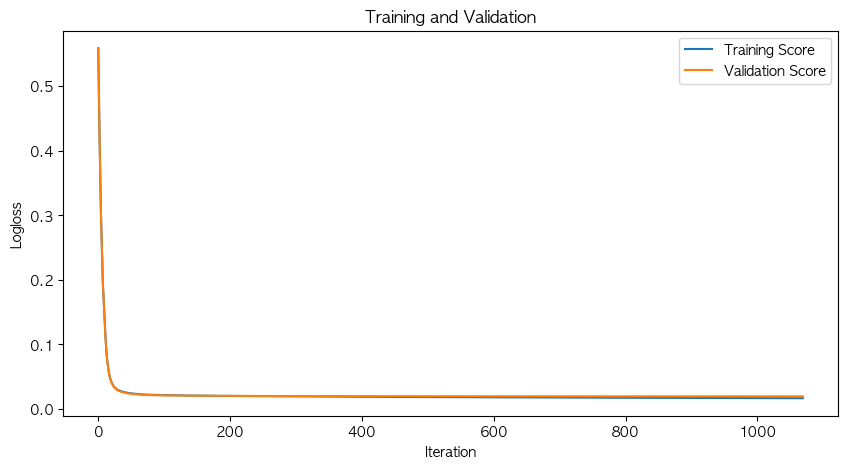

4번째 fold - accuracy: 0.9927608795427045, precision: 0.691358024691358, recall: 0.38181818181818183, macro_f1: 0.7441508794886679
4번째 fold(TEST) - accuracy: 0.9916765755053508, precision: 0.5, recall: 0.26666666666666666, macro_f1: 0.671818823525331
accuracy: 0.9923107411811336, precision: 0.5714285714285714, recall: 0.3047619047619048, macro_f1: 0.6968231036376867
최대 macro f1: 0.7128688978568112
mode macro f1: 0.6968231036376867
최종 선택은 Best 모델 1개
CPU times: user 59min 31s, sys: 1min 32s, total: 1h 1min 3s
Wall time: 9min 16s


In [255]:
%%time
max_macro_f1 = 0
best_predict = None
best_classifier = None
total_predictions = []
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    print(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트와 평가세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    y_train_fold = y_train[train_idx]
    X_valid_fold = X_train.iloc[valid_idx, :]
    y_valid_fold = y_train[valid_idx]

    # CatBoostRegressor 모델 초기화
    model = CatBoostClassifier(iterations=10000, random_state=42)

    # fold의 데이터로 학습을 진행합니다.
    model.fit(X_train_fold, y_train_fold, eval_set=(X_valid_fold, y_valid_fold),
              cat_features=categorical_columns_v2[1:], early_stopping_rounds=50, verbose=100)

    results = model.get_evals_result()

    # 훈련 및 검증 데이터셋에 대한 분류 성능 그리기
    plt.figure(figsize=(10, 5))
    plt.plot(results['learn']['Logloss'], label='Training Score')
    plt.plot(results['validation']['Logloss'], label='Validation Score')
    plt.xlabel('Iteration')
    plt.ylabel('Logloss')
    plt.title('Training and Validation')
    plt.legend()
    plt.show()
    
    fold_predicts = model.predict(X_valid_fold)

    # 평가지표 계산
    accuracy = accuracy_score(y_valid_fold, fold_predicts)
    precision = precision_score(y_valid_fold, fold_predicts)
    recall = recall_score(y_valid_fold, fold_predicts)
    macro_f1 = f1_score(y_valid_fold, fold_predicts, average='macro')

    print(f"{fold_idx}번째 fold - accuracy: {accuracy}, precision: {precision}, recall: {recall}, macro_f1: {macro_f1}")


    fold_predicts = model.predict(X_test)

    # 평가지표 계산
    accuracy = accuracy_score(y_test, fold_predicts)
    precision = precision_score(y_test, fold_predicts)
    recall = recall_score(y_test, fold_predicts)
    macro_f1 = f1_score(y_test, fold_predicts, average='macro')

    print(f"{fold_idx}번째 fold(TEST) - accuracy: {accuracy}, precision: {precision}, recall: {recall}, macro_f1: {macro_f1}")
    # 최대 f1을 갖는 모델을 추적합니다.
    if macro_f1 > max_macro_f1:
        max_macro_f1 = macro_f1
        best_predict = fold_predicts
        best_classifier = model
    
    # 각 fold의 예측값을 리스트에 추가합니다. (예측값을 리스트가 아닌 배열로 저장해야 함)
    total_predictions.append(fold_predicts.ravel())

# 각 폴드의 예측값들을 수평으로 쌓아서 2차원 배열로 만듭니다.
predictions_array = np.column_stack(total_predictions)

# 각 샘플에 대한 최빈값을 계산합니다.
mode_result = mode(predictions_array, axis=1)
mode_predictions = mode_result.mode.ravel() # 1차원 배열로 변환

# mode 예측값에 대한 평가지표를 계산합니다.
mode_accuracy = accuracy_score(y_test, mode_predictions)
mode_precision = precision_score(y_test, mode_predictions)
mode_recall = recall_score(y_test, mode_predictions)
mode_macro_f1 = f1_score(y_test, mode_predictions, average='macro')
print(f"accuracy: {mode_accuracy}, precision: {mode_precision}, recall: {mode_recall}, macro_f1: {mode_macro_f1}")

print(f"최대 macro f1: {max_macro_f1}")
print(f"mode macro f1: {mode_macro_f1}")

# 최종 예측을 선택합니다.
if mode_macro_f1 > max_macro_f1:
    pred = mode_predictions
    average = True
    print("최종 선택은 mode 모델")
else:
    pred = best_predict
    best_classifier = best_classifier
    average = False
    print("최종 선택은 Best 모델 1개")

- accuracy: 0.9782005548949663, precision: 0.8011811023622047, recall: 0.7005163511187608, macro_f1: 0.8680416693340764
- 최대 macro f1: 0.8689605661062192
- mode macro f1: 0.8680416693340764
- 최종 선택은 Best 모델 1개

In [256]:
# 회귀 모델용 데이터 분할
X_train_0 = X_train[y_train == 0]  # 아웃라이어를 제외한 훈련 데이터
# X_train의 인덱스를 사용하여 df에서 TARGET 값을 가져옵니다.
y_train_0 = df.loc[X_train_0.index, 'TARGET']  # 아웃라이어를 제외한 타겟
y_train_0.reset_index(drop=True, inplace=True)
print(X_train_0.shape, y_train_0.shape)

(237422, 17) (237422,)


In [257]:
# 회귀 모델용 데이터 분할
X_test_0 = X_test[y_test == 0]  # 아웃라이어를 제외한 훈련 데이터
# X_train의 인덱스를 사용하여 df에서 TARGET 값을 가져옵니다.
y_test_0 = df.loc[X_test_0.index, 'TARGET']  # 아웃라이어를 제외한 타겟
y_test_0.reset_index(drop=True, inplace=True)
print(X_test_0.shape, y_test_0.shape)
# print(X_test.shape, y_test.shape)

(12510, 17) (12510,)


Fold 0 :
  Train : index=[47485 47486 47487 47488 47489]...
  Valid : index=[0 1 2 3 4]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[47485 47486 47487 47488 47489]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[94970 94971 94972 94973 94974]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[142454 142455 142456 142457 142458]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[189938 189939 189940 189941 189942]...


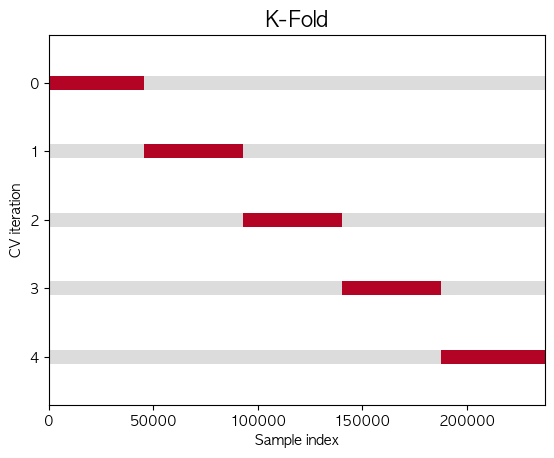

In [258]:
# Kfold 함수를 선언합니다.
kf = KFold(n_splits=5)

# kfold를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train_0,
                y=y_train_0,
                cv=kf,
                ax=ax,
                split_strategy='K-Fold')


# 학습 데이터를 Kfold로 나눕니다.
train_folds = kf.split(X_train_0, y_train_0)

--------0번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.028486
0:	learn: 3.8640920	test: 3.8352725	best: 3.8352725 (0)	total: 124ms	remaining: 20m 44s
100:	learn: 1.5945986	test: 1.5812022	best: 1.5812022 (100)	total: 9.87s	remaining: 16m 7s
200:	learn: 1.4912016	test: 1.4819141	best: 1.4819141 (200)	total: 19.9s	remaining: 16m 11s
300:	learn: 1.4574174	test: 1.4506227	best: 1.4506227 (300)	total: 30s	remaining: 16m 6s
400:	learn: 1.4387659	test: 1.4357594	best: 1.4357594 (400)	total: 40.2s	remaining: 16m 2s
500:	learn: 1.4259371	test: 1.4261070	best: 1.4261070 (500)	total: 51.1s	remaining: 16m 9s
600:	learn: 1.4176631	test: 1.4205431	best: 1.4205431 (600)	total: 1m 2s	remaining: 16m 10s
700:	learn: 1.4110439	test: 1.4163418	best: 1.4163418 (700)	total: 1m 13s	remaining: 16m 11s
800:	learn: 1.4058805	test: 1.4136115	best: 1.4136115 (800)	total: 1m 23s	remaining: 16m 4s
900:	learn: 1.4015644	test: 1.4111878	best: 1.4111878 (900)	total: 1m 34s	remaining: 15m 58s
1000:	learn: 1.397331

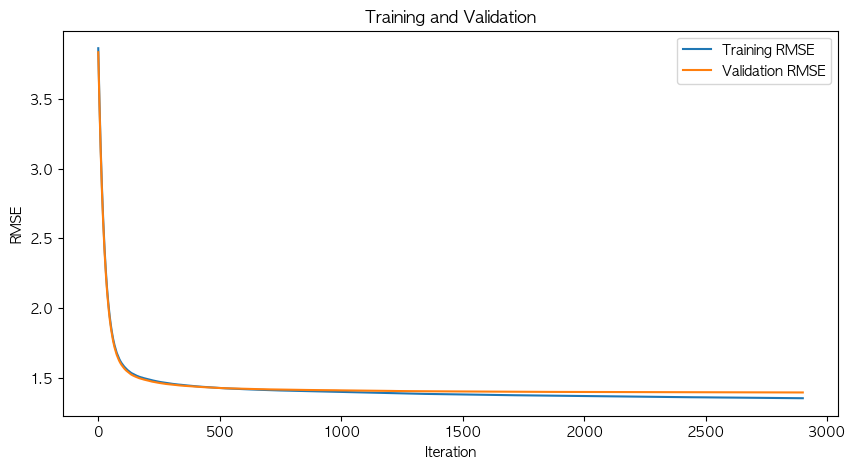

0번째 fold - mae: 0.6684212026790876, mse: 1.9433829595824836, rmse: 1.3940527104749245, r2: 0.8736095746838634
0번째 fold(TEST) - mae: 0.6548476344408949, mse: 1.9244817542945143, rmse: 1.3872569171910856, r2: 0.8772108400877285
--------1번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.028486
0:	learn: 3.8493490	test: 3.8939317	best: 3.8939317 (0)	total: 102ms	remaining: 17m 2s
100:	learn: 1.5888955	test: 1.6017551	best: 1.6017551 (100)	total: 10.7s	remaining: 17m 31s
200:	learn: 1.4865648	test: 1.4986022	best: 1.4986022 (200)	total: 20.8s	remaining: 16m 53s
300:	learn: 1.4553428	test: 1.4699544	best: 1.4699544 (300)	total: 31s	remaining: 16m 38s
400:	learn: 1.4370589	test: 1.4538200	best: 1.4538200 (400)	total: 41.3s	remaining: 16m 27s
500:	learn: 1.4246009	test: 1.4441200	best: 1.4441200 (500)	total: 51.6s	remaining: 16m 19s
600:	learn: 1.4159198	test: 1.4386064	best: 1.4386064 (600)	total: 1m 2s	remaining: 16m 11s
700:	learn: 1.4094731	test: 1.4348423	best: 1.4348423 (700)	total: 1m 

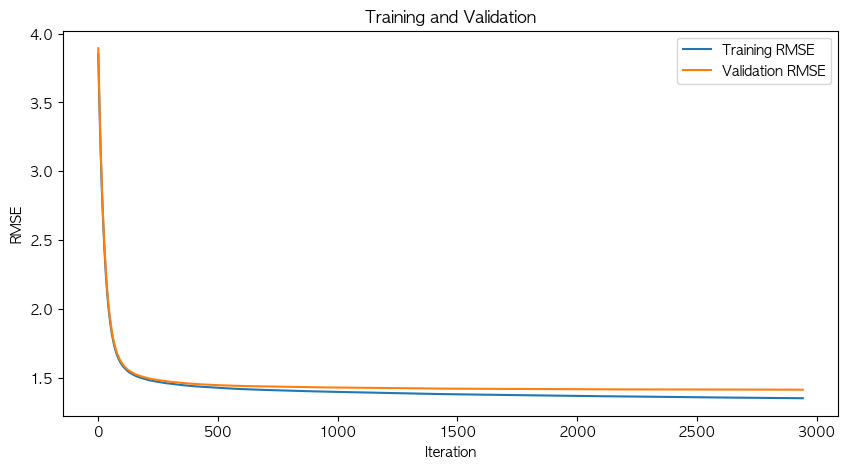

1번째 fold - mae: 0.6713431697100984, mse: 1.9922737965590895, rmse: 1.4114792937053982, r2: 0.8742624287100036
1번째 fold(TEST) - mae: 0.6551743213857886, mse: 1.9290043819907703, rmse: 1.388886021958163, r2: 0.8769222794639762
--------2번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.028486
0:	learn: 3.8533700	test: 3.8784178	best: 3.8784178 (0)	total: 115ms	remaining: 19m 7s
100:	learn: 1.5859288	test: 1.6129727	best: 1.6129727 (100)	total: 10.5s	remaining: 17m 7s
200:	learn: 1.4818945	test: 1.5069449	best: 1.5069449 (200)	total: 20.6s	remaining: 16m 46s
300:	learn: 1.4495614	test: 1.4769798	best: 1.4769798 (300)	total: 30.9s	remaining: 16m 34s
400:	learn: 1.4322155	test: 1.4621427	best: 1.4621427 (400)	total: 41.1s	remaining: 16m 23s
500:	learn: 1.4192373	test: 1.4520430	best: 1.4520430 (500)	total: 51.1s	remaining: 16m 9s
600:	learn: 1.4109568	test: 1.4463857	best: 1.4463857 (600)	total: 1m 1s	remaining: 16m 5s
700:	learn: 1.4053036	test: 1.4430602	best: 1.4430602 (700)	total: 1m 12

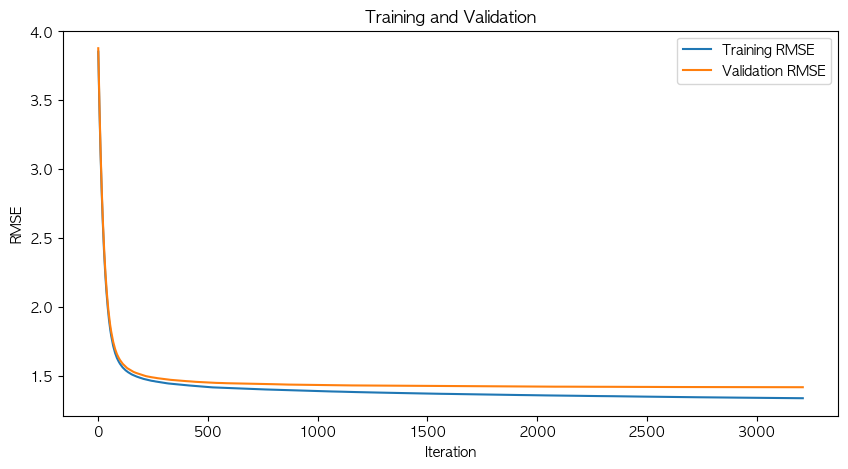

2번째 fold - mae: 0.6679672361039379, mse: 2.0103208825904173, rmse: 1.4178578499237564, r2: 0.8721069903065211
2번째 fold(TEST) - mae: 0.6520661387753989, mse: 1.9421908782385118, rmse: 1.3936250852501586, r2: 0.8760809315048005
--------3번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.028486
0:	learn: 3.8706416	test: 3.8077449	best: 3.8077449 (0)	total: 99.5ms	remaining: 16m 34s
100:	learn: 1.5880630	test: 1.5797526	best: 1.5797526 (100)	total: 10.3s	remaining: 16m 53s
200:	learn: 1.4862482	test: 1.4899499	best: 1.4899499 (200)	total: 20.7s	remaining: 16m 50s
300:	learn: 1.4522086	test: 1.4603317	best: 1.4603317 (300)	total: 30.6s	remaining: 16m 27s
400:	learn: 1.4338162	test: 1.4449732	best: 1.4449732 (400)	total: 41.4s	remaining: 16m 30s
500:	learn: 1.4224188	test: 1.4363330	best: 1.4363330 (500)	total: 51.7s	remaining: 16m 20s
600:	learn: 1.4146647	test: 1.4307946	best: 1.4307946 (600)	total: 1m 2s	remaining: 16m 11s
700:	learn: 1.4088007	test: 1.4268031	best: 1.4268031 (700)	total:

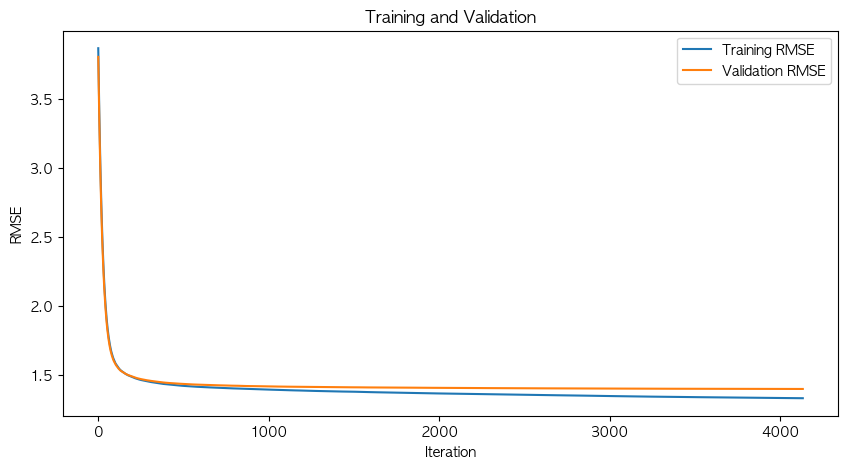

3번째 fold - mae: 0.6664241753369349, mse: 1.959989908219466, rmse: 1.399996395788027, r2: 0.8707029152029083
3번째 fold(TEST) - mae: 0.6543087125907682, mse: 1.9269272721982118, rmse: 1.3881380594876764, r2: 0.8770548068656544
--------4번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.028486
0:	learn: 3.8556040	test: 3.8769379	best: 3.8769379 (0)	total: 113ms	remaining: 18m 47s
100:	learn: 1.5888393	test: 1.5822880	best: 1.5822880 (100)	total: 10.5s	remaining: 17m 10s
200:	learn: 1.4857699	test: 1.4836771	best: 1.4836771 (200)	total: 21.3s	remaining: 17m 19s
300:	learn: 1.4554877	test: 1.4566799	best: 1.4566799 (300)	total: 31.3s	remaining: 16m 49s
400:	learn: 1.4386439	test: 1.4428976	best: 1.4428976 (400)	total: 41.7s	remaining: 16m 38s
500:	learn: 1.4270626	test: 1.4340841	best: 1.4340841 (500)	total: 52.3s	remaining: 16m 30s
600:	learn: 1.4184986	test: 1.4278846	best: 1.4278846 (600)	total: 1m 3s	remaining: 16m 27s
700:	learn: 1.4119838	test: 1.4237441	best: 1.4237441 (700)	total: 1m

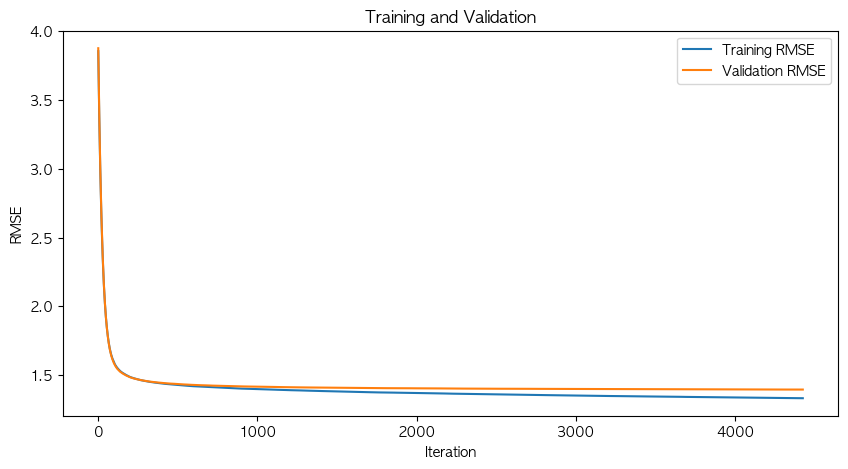

4번째 fold - mae: 0.6644493800473575, mse: 1.9439105026832029, rmse: 1.3942419096710594, r2: 0.8761917308711109
4번째 fold(TEST) - mae: 0.6522273055254939, mse: 1.931941914774065, rmse: 1.3899431336475838, r2: 0.8767348538456918
최소 RMSE: 1.3872569171910856
평균 예측 RMSE: 1.3845087481718403
최종 선택은 평균값 모델
CPU times: user 3h 19min 40s, sys: 4min 9s, total: 3h 23min 50s
Wall time: 31min 7s


In [259]:
%%time
min_rmse = float('inf')
best_predict = None
best_reg_0 = None
total_predictions = []
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    print(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트와 평가세트를 가져옵니다.
    X_train_fold = X_train_0.iloc[train_idx, :]
    y_train_fold = y_train_0[train_idx]
    X_valid_fold = X_train_0.iloc[valid_idx, :]
    y_valid_fold = y_train_0[valid_idx]

    # CatBoostRegressor 모델 초기화
    model = CatBoostRegressor(iterations=10000, loss_function='RMSE', random_state=42)

    # fold의 데이터로 학습을 진행합니다.
    model.fit(X_train_fold, y_train_fold, eval_set=(X_valid_fold, y_valid_fold),
              cat_features=categorical_columns_v2[1:], early_stopping_rounds=50, verbose=100)

    results = model.get_evals_result()

    # 훈련 및 검증 데이터셋에 대한 분류 성능 그리기
    plt.figure(figsize=(10, 5))
    plt.plot(results['learn']['RMSE'], label='Training RMSE')
    plt.plot(results['validation']['RMSE'], label='Validation RMSE')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('Training and Validation')
    plt.legend()
    plt.show()
    
    fold_predicts = model.predict(X_valid_fold)

    # 평가지표 계산
    mae = mean_absolute_error(y_valid_fold, fold_predicts)
    mse = mean_squared_error(y_valid_fold, fold_predicts)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_valid_fold, fold_predicts)

    print(f"{fold_idx}번째 fold - mae: {mae}, mse: {mse}, rmse: {rmse}, r2: {r2}")


    fold_predicts = model.predict(X_test_0)

    # 평가지표 계산
    mae = mean_absolute_error(y_test_0, fold_predicts)
    mse = mean_squared_error(y_test_0, fold_predicts)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_0, fold_predicts)

    print(f"{fold_idx}번째 fold(TEST) - mae: {mae}, mse: {mse}, rmse: {rmse}, r2: {r2}")
    # 최소 RMSE를 갖는 모델을 추적합니다.
    if rmse < min_rmse:
        min_rmse = rmse
        best_predict = fold_predicts
        best_reg_0 = model

    # 각 fold의 예측값을 리스트에 추가합니다.
    total_predictions.append(fold_predicts)

# 예측값의 평균을 계산합니다.
average_predictions = np.mean(total_predictions, axis=0)

# 평균 예측에 대한 RMSE를 계산합니다.
average_rmse = np.sqrt(mean_squared_error(y_test_0, average_predictions))

print(f"최소 RMSE: {min_rmse}")
print(f"평균 예측 RMSE: {average_rmse}")

# 최종 예측을 선택합니다.
if average_rmse < min_rmse:
    pred = average_predictions
    average = True
    print("최종 선택은 평균값 모델")
else:
    pred = best_predict
    best_reg_0 = best_reg_0
    average = False
    print("최종 선택은 Best 모델 1개")

- 최소 RMSE: 0.9182625945063093
- 평균 예측 RMSE: 0.916714583019966
- 최종 선택은 평균값 모델

In [260]:
# 회귀 모델용 데이터 분할
X_train_1 = X_train[y_train == 1]  # 아웃라이어를 퐇함한 훈련 데이터
# X_train의 인덱스를 사용하여 df에서 TARGET 값을 가져옵니다.
y_train_1 = df.loc[X_train_1.index, 'TARGET']  # 아웃라이어를 포함한 타겟
y_train_1.reset_index(drop=True, inplace=True)
print(X_train_1.shape, y_train_1.shape)

(2252, 17) (2252,)


In [261]:
# 회귀 모델용 데이터 분할
X_test_1 = X_test[y_test == 1]  # 아웃라이어를 제외한 훈련 데이터
# X_train의 인덱스를 사용하여 df에서 TARGET 값을 가져옵니다.
y_test_1 = df.loc[X_test_1.index, 'TARGET']  # 아웃라이어를 제외한 타겟
y_test_1.reset_index(drop=True, inplace=True)
print(X_test_1.shape, y_test_1.shape)
# print(X_test.shape, y_test.shape)

(105, 17) (105,)


Fold 0 :
  Train : index=[451 452 453 454 455]...
  Valid : index=[0 1 2 3 4]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[451 452 453 454 455]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[902 903 904 905 906]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[1352 1353 1354 1355 1356]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[1802 1803 1804 1805 1806]...


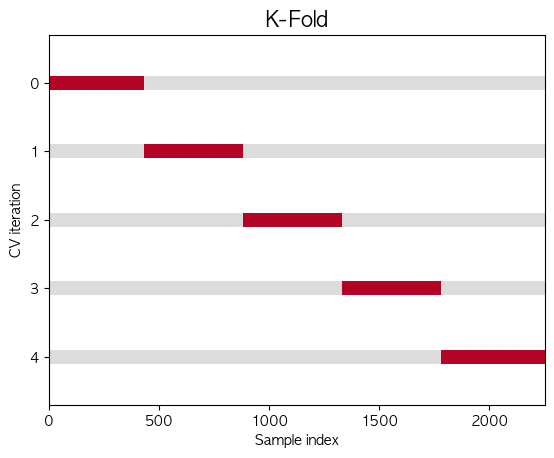

In [262]:
# Kfold 함수를 선언합니다.
kf = KFold(n_splits=5)

# kfold를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train_1,
                y=y_train_1,
                cv=kf,
                ax=ax,
                split_strategy='K-Fold')


# 학습 데이터를 Kfold로 나눕니다.
train_folds = kf.split(X_train_1, y_train_1)

--------0번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.013709
0:	learn: 19.5854250	test: 13.2296542	best: 13.2296542 (0)	total: 2.23ms	remaining: 22.3s
100:	learn: 17.8462534	test: 12.8864007	best: 12.8684178 (93)	total: 362ms	remaining: 35.5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 12.86841781
bestIteration = 93

Shrink model to first 94 iterations.


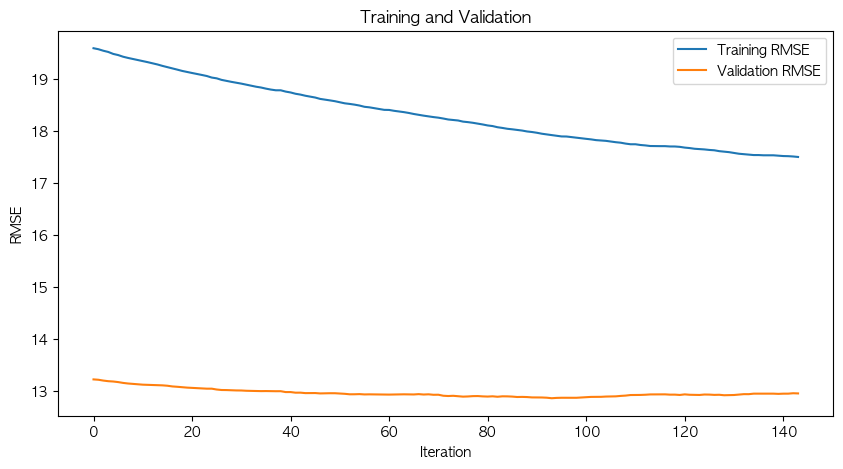

0번째 fold - mae: 8.808067146956327, mse: 165.59617693804702, rmse: 12.868417810206779, r2: 0.048815785182519056
0번째 fold(TEST) - mae: 9.014592164934358, mse: 238.00916240678853, rmse: 15.42754557299341, r2: 0.09471279233762309
--------1번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.013709
0:	learn: 19.0828587	test: 15.8800825	best: 15.8800825 (0)	total: 4.26ms	remaining: 42.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 15.86693273
bestIteration = 8

Shrink model to first 9 iterations.


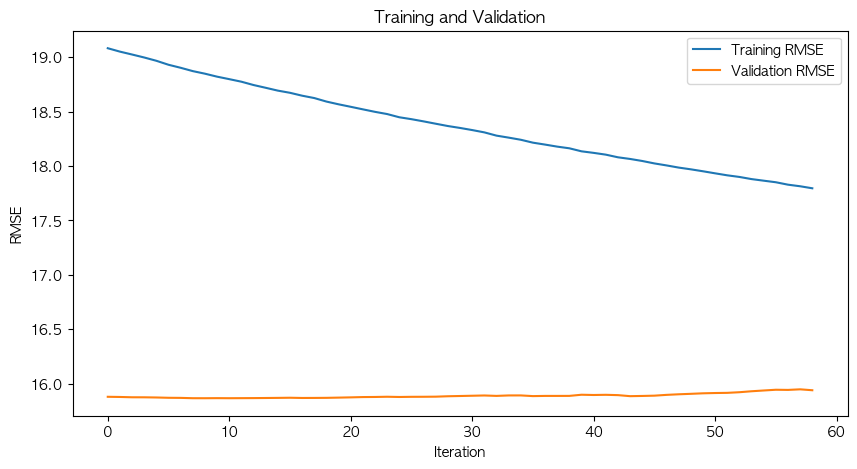

1번째 fold - mae: 9.9087783220453, mse: 251.75955413994026, rmse: 15.866932726268812, r2: 0.0007320995947326381
1번째 fold(TEST) - mae: 9.475649254315593, mse: 258.9872757905466, rmse: 16.093081612623067, r2: 0.014920831830032899
--------2번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.01371
0:	learn: 18.7208701	test: 17.5303554	best: 17.5303554 (0)	total: 4.47ms	remaining: 44.7s
100:	learn: 16.9658755	test: 16.9133583	best: 16.9133583 (100)	total: 345ms	remaining: 33.8s
200:	learn: 16.0456612	test: 16.6431701	best: 16.6431701 (200)	total: 681ms	remaining: 33.2s
300:	learn: 15.5058591	test: 16.5782533	best: 16.5669302 (291)	total: 996ms	remaining: 32.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 16.56693022
bestIteration = 291

Shrink model to first 292 iterations.


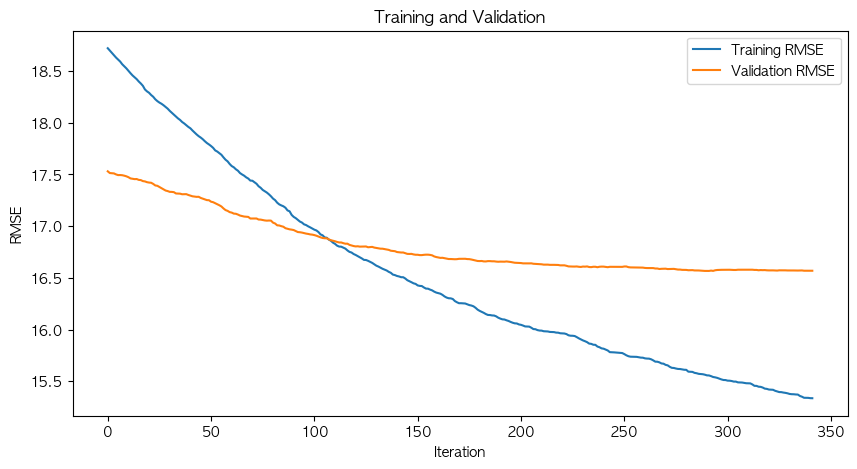

2번째 fold - mae: 9.669128590597067, mse: 274.4631769556996, rmse: 16.56693022124798, r2: 0.10802984384567638
2번째 fold(TEST) - mae: 9.02477253929568, mse: 205.94499729038753, rmse: 14.350783856305116, r2: 0.2166714522930775
--------3번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.01371
0:	learn: 15.5407987	test: 27.3038596	best: 27.3038596 (0)	total: 3.36ms	remaining: 33.6s
100:	learn: 14.5086964	test: 26.7840570	best: 26.7840570 (100)	total: 335ms	remaining: 32.8s
200:	learn: 14.0511896	test: 26.5353463	best: 26.5353463 (200)	total: 645ms	remaining: 31.4s
300:	learn: 13.7515366	test: 26.3589988	best: 26.3589988 (300)	total: 945ms	remaining: 30.4s
400:	learn: 13.4906105	test: 26.2670119	best: 26.2665952 (399)	total: 1.25s	remaining: 30s
500:	learn: 13.2752444	test: 26.1557294	best: 26.1555505 (499)	total: 1.67s	remaining: 31.6s
600:	learn: 13.0843117	test: 26.0398560	best: 26.0397124 (598)	total: 1.99s	remaining: 31.1s
700:	learn: 12.9067452	test: 25.9360928	best: 25.9348041 (696)	tot

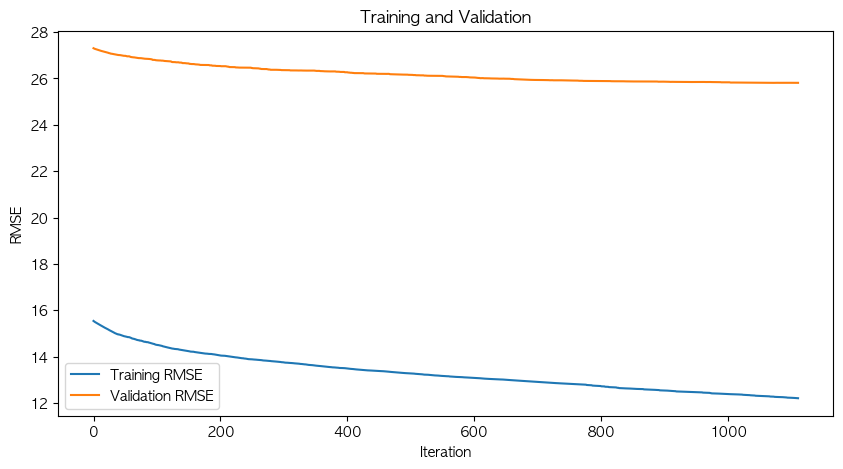

3번째 fold - mae: 9.889473410709446, mse: 666.0751254239428, rmse: 25.808431285607863, r2: 0.10283063340623722
3번째 fold(TEST) - mae: 8.599792437983343, mse: 146.52046338273055, rmse: 12.104563741941737, r2: 0.44269750029855814
--------4번째 fold의 학습을 시작합니다.--------
Learning rate set to 0.01371
0:	learn: 19.1985930	test: 15.2935985	best: 15.2935985 (0)	total: 2.49ms	remaining: 24.9s
100:	learn: 17.3429497	test: 14.8397000	best: 14.8397000 (100)	total: 420ms	remaining: 41.2s
200:	learn: 16.3568495	test: 14.7002791	best: 14.7002791 (200)	total: 763ms	remaining: 37.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 14.69384271
bestIteration = 249

Shrink model to first 250 iterations.


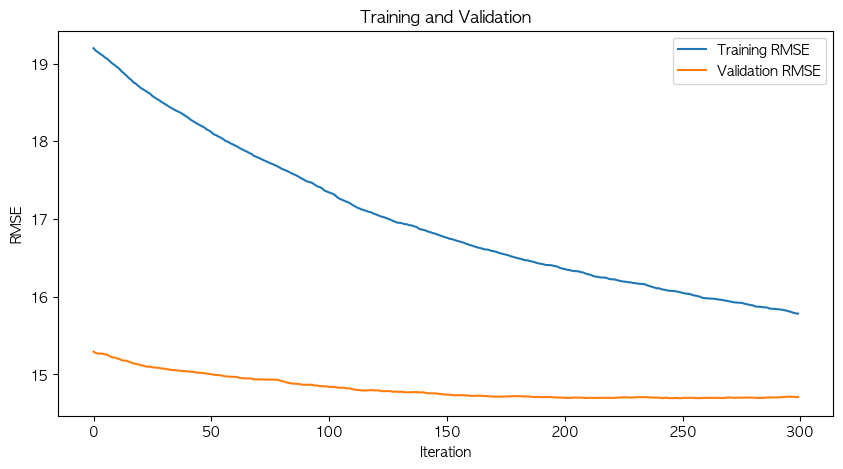

4번째 fold - mae: 9.472434818267761, mse: 215.9090136773314, rmse: 14.69384271310032, r2: 0.07740341741645107
4번째 fold(TEST) - mae: 8.98527256370673, mse: 216.44744759226097, rmse: 14.712153057668377, r2: 0.17672452835430097
최소 RMSE: 12.104563741941737
평균 예측 RMSE: 14.119332073842257
최종 선택은 Best 모델 1개
CPU times: user 25.2 s, sys: 5.56 s, total: 30.7 s
Wall time: 7.56 s


In [263]:
%%time
min_rmse = float('inf')
best_predict = None
best_reg_1 = None
total_predictions = []
fold_save_files = []

for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    print(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트와 평가세트를 가져옵니다.
    X_train_fold = X_train_1.iloc[train_idx, :]
    y_train_fold = y_train_1[train_idx]
    X_valid_fold = X_train_1.iloc[valid_idx, :]
    y_valid_fold = y_train_1[valid_idx]

    # CatBoostRegressor 모델 초기화
    model = CatBoostRegressor(iterations=10000, loss_function='RMSE', random_state=42)

    # fold의 데이터로 학습을 진행합니다.
    model.fit(X_train_fold, y_train_fold, eval_set=(X_valid_fold, y_valid_fold),
              cat_features=categorical_columns_v2[1:], early_stopping_rounds=50, verbose=100)

    results = model.get_evals_result()

    # 훈련 및 검증 데이터셋에 대한 분류 성능 그리기
    plt.figure(figsize=(10, 5))
    plt.plot(results['learn']['RMSE'], label='Training RMSE')
    plt.plot(results['validation']['RMSE'], label='Validation RMSE')
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('Training and Validation')
    plt.legend()
    plt.show()
    
    fold_predicts = model.predict(X_valid_fold)

    # 평가지표 계산
    mae = mean_absolute_error(y_valid_fold, fold_predicts)
    mse = mean_squared_error(y_valid_fold, fold_predicts)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_valid_fold, fold_predicts)

    print(f"{fold_idx}번째 fold - mae: {mae}, mse: {mse}, rmse: {rmse}, r2: {r2}")


    fold_predicts = model.predict(X_test_1)

    # 평가지표 계산
    mae = mean_absolute_error(y_test_1, fold_predicts)
    mse = mean_squared_error(y_test_1, fold_predicts)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_1, fold_predicts)

    print(f"{fold_idx}번째 fold(TEST) - mae: {mae}, mse: {mse}, rmse: {rmse}, r2: {r2}")
    # 최소 RMSE를 갖는 모델을 추적합니다.
    if rmse < min_rmse:
        min_rmse = rmse
        best_predict = fold_predicts
        best_reg_1 = model

    # 각 fold의 예측값을 리스트에 추가합니다.
    total_predictions.append(fold_predicts)

# 예측값의 평균을 계산합니다.
average_predictions = np.mean(total_predictions, axis=0)

# 평균 예측에 대한 RMSE를 계산합니다.
average_rmse = np.sqrt(mean_squared_error(y_test_1, average_predictions))

print(f"최소 RMSE: {min_rmse}")
print(f"평균 예측 RMSE: {average_rmse}")

# 최종 예측을 선택합니다.
if average_rmse < min_rmse:
    pred = average_predictions
    average = True
    print("최종 선택은 평균값 모델")
else:
    pred = best_predict
    best_reg_1 = best_reg_1
    average = False
    print("최종 선택은 Best 모델 1개")

- 최소 RMSE: 8.191018391822924
- 평균 예측 RMSE: 8.336342132920292
- 최종 선택은 Best 모델 1개

In [264]:
class_pred = best_classifier.predict(test.drop(columns=['sessionID']))
test["Outlier"] = class_pred
X_test_1 = X_test[y_test == 1]

In [265]:
# Outlier가 0인 데이터에 대한 예측
non_outlier_data = test[test["Outlier"] == 0].drop(columns=["Outlier", "sessionID"])  # Outlier와 sessionID 컬럼 제거
non_outlier_predictions = best_reg_0.predict(non_outlier_data)

# Outlier가 1인 데이터에 대한 예측
outlier_data = test[test["Outlier"] == 1].drop(columns=["Outlier", "sessionID"])  # Outlier와 sessionID 컬럼 제거
outlier_predictions = best_reg_1.predict(outlier_data)

# 예측 결과를 다시 원본 데이터프레임에 추가
test.loc[test["Outlier"] == 0, "pred"] = non_outlier_predictions
test.loc[test["Outlier"] == 1, "pred"] = outlier_predictions

In [266]:
submission = pd.read_csv('./sample_submission.csv')
submission

,sessionID,TARGET
0,SESSION_252289,0
1,SESSION_252290,0
2,SESSION_252291,0
3,SESSION_252292,0
4,SESSION_252293,0
...,...,...
79781,SESSION_332070,0
79782,SESSION_332071,0
79783,SESSION_332072,0
79784,SESSION_332073,0


In [267]:
submission['TARGET'] = test['pred']
submission

,sessionID,TARGET
0,SESSION_252289,20.235951
1,SESSION_252290,0.999168
2,SESSION_252291,2.740597
3,SESSION_252292,4.263957
4,SESSION_252293,10.074535
...,...,...
79781,SESSION_332070,1.044841
79782,SESSION_332071,1.042548
79783,SESSION_332072,2.681083
79784,SESSION_332073,4.918482


In [268]:
submission.to_csv(f"ensemble_kfold_240302(2).csv", index=False)